In [64]:
from sympy import symbols, init_printing
init_printing()
from celmech.hamiltonian import AndoyerHamiltonian
from celmech.transformations import poincare_vars_to_andoyer_vars, poincare_vars_from_sim
from celmech.transformations import jacobi_masses_from_sim, get_andoyer_params
from celmech.transformations import andoyer_vars_to_poincare_vars, andoyer_vars_from_sim

In [65]:
import rebound
import numpy as np

def make_sim(j, k):
    mass = 1.e-5
    e0 = 0.1 # initial eccentricity of planets
    
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=mass, e=e0, pomega = np.pi/2., P=1., theta=np.pi)
    sim.add(m=2*mass, e=1.e-5, pomega=0., P=j/float(j-k))
    sim.move_to_com()
    return sim

j=7
k=2
sim = make_sim(j,k)

In [66]:
sim = make_sim(j,k)
ps = sim.particles
a10 = ps[1].a
a20 = ps[2].a

andvars, params = andoyer_vars_from_sim(sim, j, k, a10, a20, average_synodic_terms=True)
Phi0, phi0, W0, w0, B0, K0, A0, B0, C0 = andvars
Phiscale, timescale, Phiprime = params
Hsim = AndoyerHamiltonian(k, Phiprime, Phi0, phi0)

Norbits = 3000
Nout = 1000
tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout)
symtimes = times/abs(timescale)

Nsol = np.zeros((2, Nout))
symsol = np.zeros((2, Nout))
pratio, BrouwerErr, WErr, Ks = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)

for i, time in enumerate(times):
    pratio[i] = ps[2].P/ps[1].P
    andvars, params = andoyer_vars_from_sim(sim, j, k, a10, a20, average_synodic_terms=True)
    Phi, phi, W, w, B, K, A, B, C = andvars
    BrouwerErr[i] = abs((B-B0)/B0)
    WErr[i] = abs((W-W0)/W0)
    Ks[i] = K

    symsol[:,i] = Hsim.integrator.y
    Nsol[:,i] = [Phi, phi]

    sim.integrate(np.sign(timescale)*time)    
    Hsim.integrate(symtimes[i])

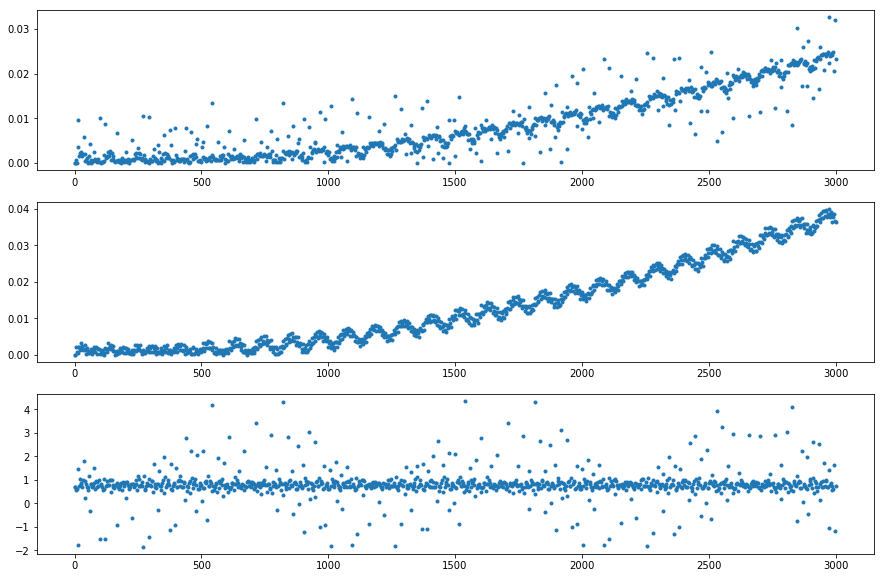

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axarr = plt.subplots(figsize=(15,10), nrows=3)
axarr[0].plot(times, BrouwerErr, '.')
axarr[1].plot(times, WErr, '.')
axarr[2].plot(times, Ks, '.')

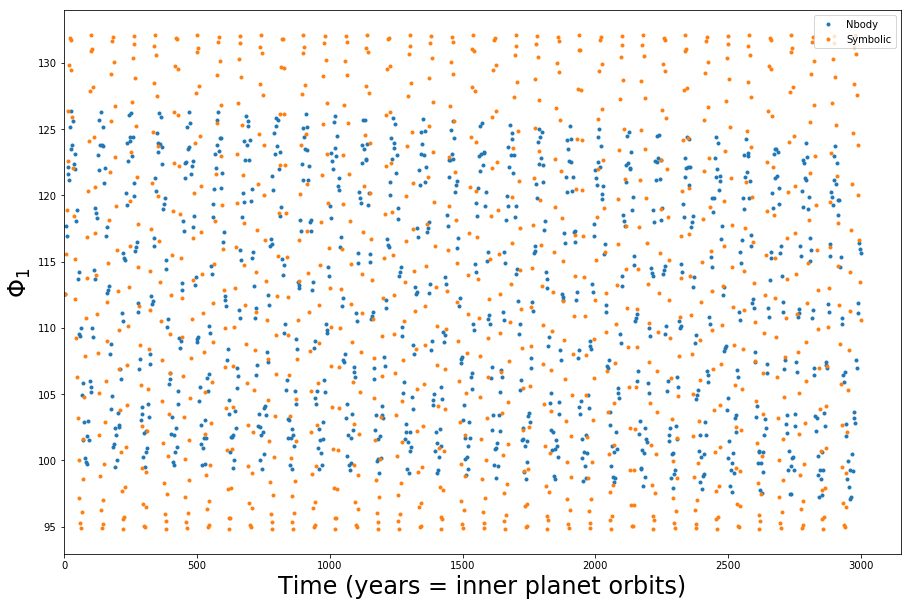

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$\Phi_1$", fontsize=24)

ax.plot(times, Nsol[0,:], '.', label='Nbody')
ax.plot(times, symsol[0,:], '.', label='Symbolic')

ax.legend()
ax.set_xlim(xmin=-3)

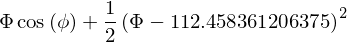

In [69]:
Hsim.NH

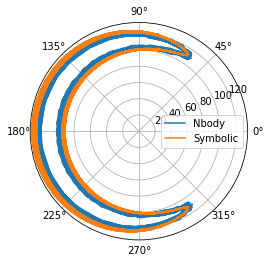

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = plt.subplot('111', projection='polar')
ax.plot(Nsol[1,:], Nsol[0,:], label='Nbody')
ax.plot(symsol[1,:], symsol[0,:], label='Symbolic')
ax.legend()